In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.losses import *

In [90]:
def SMAPE(y_true, y_pred):
    N = tf.cast(tf.shape(y_true, out_type=tf.int32)[-1], dtype=tf.float32)
    t1 = tf.math.pow(tf.math.abs(tf.math.subtract(y_pred, y_true)), tf.constant(2.0, dtype=tf.float32))
    t2 = tf.math.minimum( tf.math.multiply(tf.constant(2.0, dtype=tf.float32),tf.math.abs(y_true)), tf.math.abs(y_pred))
    t3 = tf.math.pow(tf.math.add(t2, tf.math.abs(y_true)), tf.constant(2.0, dtype=tf.float32))
    t4 = tf.math.divide(t1, t3)
    m = tf.math.multiply(tf.math.divide(tf.constant(100.0,dtype=tf.float32), N), t4)
    res = tf.math.subtract(tf.constant(100.0,dtype=tf.float32), m)
    return res

def test_SMAPE(y_true, y_pred):
    score = 100
    val = 0
    for i in range(y_true.shape[0]):
        val += abs(y_pred[i]-y_true[i])**2/(min(2*abs(y_true[i]),abs(y_pred[i])) + abs(y_true[i]) )**2
    score -= (100/y_true.shape[0])*val
    return score

In [91]:
# callback_list = [
#     ModelCheckpoint(filepath='saved_weight/Too_1_{epoch:02d}.hdf5', verbose=1, period=200),
    
# ]


def get_nn_model_1(lr=7e-3, amsgrad=True, n_feature=3, l2_kernel=0.01, l1_act=0.01, decay=0.001):
    adam = Adam(lr=lr, decay=decay, amsgrad=amsgrad)
    model = Sequential()
    model.add(Dense(1024, input_shape=(n_feature,), kernel_regularizer=tf.keras.regularizers.l2(l2_kernel), \
                    activity_regularizer=tf.keras.regularizers.l1(l1_act),
                   kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(512, kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(128, kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='he_normal'))
    model.add(LeakyReLU())
    model.compile(loss='mse', optimizer=adam, metrics=[SMAPE])
    model.build()
    model.summary()
    return model
model = get_nn_model_1(n_feature=7)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 1024)              8192      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_48 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
dense_49 (Dense)             (None, 256)             

In [92]:
norm_df = pd.read_csv('data_df.csv')
train_df = pd.read_csv('train.csv')

In [93]:
whole_df = pd.merge(norm_df, train_df, on='id', how='inner')

# random data
random_state = np.random.randint(1024)
train_set = whole_df.sample(frac=0.90, random_state=random_state)
test_set = whole_df.drop(train_set.index)

train_set.head()

,id,gender,ocp_cd,age,cc_txn_amt,cc_count,kp_txn_count,kp_txn_amt,income
45373,45374,1,3.0,4,151600.0,51.0,74.0,751300.0,51000
30121,30122,2,9.0,3,8400.0,4.0,90.0,267400.0,49000
18916,18917,1,3.0,4,0.0,0.0,137.0,325200.0,95000
33011,33012,1,3.0,4,16000.0,8.0,0.0,0.0,18000
22759,22760,2,9.0,4,88600.0,13.0,42.0,81100.0,29000


In [94]:
def df2np(df):
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
   
    y = None
    if 'income' in df.columns:
        y = df['income'].to_numpy()
        df = df.drop('income', axis=1)
    x = df.to_numpy()
    return x, y

In [95]:
x_train, y_train = df2np(train_set)
x_test, y_test = df2np(test_set)

In [96]:
hist = model.fit(x=x_train,y=y_train, epochs=150, batch_size=1024, shuffle=True,validation_data=(x_test, y_test), verbose=1)
# _y = model.predict(x_test)
#     print('test_SMAPE:',test_SMAPE(y_test, _y))

Train on 45000 samples, validate on 5000 samples
Epoch 1/150
45000/45000 [==============================] - 7s 150us/sample - loss: 5092888467.9566 - SMAPE: 0.1563 - val_loss: 5479775203.3280 - val_SMAPE: 0.1400
Epoch 2/150
45000/45000 [==============================] - 4s 97us/sample - loss: 5085300491.1502 - SMAPE: 0.6309 - val_loss: 5492964098.8672 - val_SMAPE: 0.1676
Epoch 3/150
45000/45000 [==============================] - 4s 98us/sample - loss: 5071751837.1954 - SMAPE: 1.5333 - val_loss: 5515047201.9968 - val_SMAPE: 0.3208
Epoch 4/150
45000/45000 [==============================] - 4s 98us/sample - loss: 5052221726.3559 - SMAPE: 2.8512 - val_loss: 5497490192.7936 - val_SMAPE: 0.5291
Epoch 5/150
45000/45000 [==============================] - 4s 99us/sample - loss: 5027337899.2128 - SMAPE: 4.4638 - val_loss: 5526445712.9984 - val_SMAPE: 0.4944
Epoch 6/150
45000/45000 [==============================] - 4s 99us/sample - loss: 4997293701.0745 - SMAPE: 6.4059 - val_loss: 5474232880.332

45000/45000 [==============================] - 4s 95us/sample - loss: 3275886904.5703 - SMAPE: 66.6282 - val_loss: 4177918269.4400 - val_SMAPE: 26.6448
Epoch 51/150
45000/45000 [==============================] - 4s 95us/sample - loss: 3240667138.2756 - SMAPE: 67.0443 - val_loss: 3186352590.8480 - val_SMAPE: 87.1819
Epoch 52/150
45000/45000 [==============================] - 5s 105us/sample - loss: 3220511760.4750 - SMAPE: 67.3137 - val_loss: 3115371313.9712 - val_SMAPE: 83.8134
Epoch 53/150
45000/45000 [==============================] - 4s 95us/sample - loss: 3198028216.2745 - SMAPE: 67.5943 - val_loss: 2694973177.8560 - val_SMAPE: 81.1345
Epoch 54/150
45000/45000 [==============================] - 4s 95us/sample - loss: 3170372436.2866 - SMAPE: 68.3358 - val_loss: 2850767599.6160 - val_SMAPE: 89.3237
Epoch 55/150
45000/45000 [==============================] - 4s 96us/sample - loss: 3148168762.2542 - SMAPE: 68.0902 - val_loss: 3513064173.5680 - val_SMAPE: 84.5949
Epoch 56/150
45000/450

45000/45000 [==============================] - 4s 99us/sample - loss: 2540504908.5952 - SMAPE: 77.3119 - val_loss: 2683139205.5296 - val_SMAPE: 85.7654
Epoch 100/150
45000/45000 [==============================] - 5s 100us/sample - loss: 2528957031.9929 - SMAPE: 78.1608 - val_loss: 2666928075.1616 - val_SMAPE: 89.1733
Epoch 101/150
45000/45000 [==============================] - 4s 92us/sample - loss: 2517297879.3586 - SMAPE: 77.7778 - val_loss: 2597681066.3936 - val_SMAPE: 85.1418
Epoch 102/150
45000/45000 [==============================] - 4s 94us/sample - loss: 2508566358.4256 - SMAPE: 78.0273 - val_loss: 2689255480.9344 - val_SMAPE: 88.9100
Epoch 103/150
45000/45000 [==============================] - 4s 93us/sample - loss: 2503671423.5676 - SMAPE: 77.8175 - val_loss: 2683432464.7936 - val_SMAPE: 87.4719
Epoch 104/150
45000/45000 [==============================] - 4s 92us/sample - loss: 2513641256.3684 - SMAPE: 78.4547 - val_loss: 2600740468.3264 - val_SMAPE: 85.0887
Epoch 105/150
450

45000/45000 [==============================] - 4s 91us/sample - loss: 2302958087.7369 - SMAPE: 81.9887 - val_loss: 2472153496.7808 - val_SMAPE: 81.2731
Epoch 149/150
45000/45000 [==============================] - 4s 90us/sample - loss: 2299696601.1563 - SMAPE: 82.3498 - val_loss: 3054801210.5728 - val_SMAPE: 59.9104
Epoch 150/150
45000/45000 [==============================] - 4s 92us/sample - loss: 2297291477.3561 - SMAPE: 82.6255 - val_loss: 2457266468.4544 - val_SMAPE: 86.1099


In [97]:
# model.save_weights('./weights/too_model.hdf5')

In [98]:
loss,val_loss, score,val_score = hist.history['loss'],hist.history['val_loss'], hist.history['SMAPE'], hist.history['val_SMAPE']

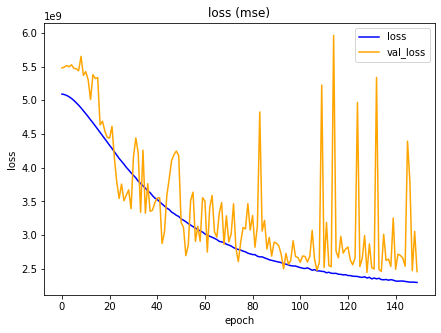

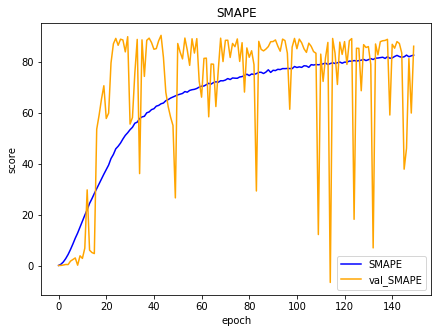

In [99]:
plt.figure(figsize=(7,5))
plt.title('loss (mse)')
plt.plot(np.arange(len(loss)),loss,label='loss',color='blue')
plt.plot(np.arange(len(val_loss)),val_loss,label='val_loss',color='orange')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('SMAPE')
plt.plot(np.arange(len(score)),score,label='SMAPE',color='blue')
plt.plot(np.arange(len(val_score)),val_score,label='val_SMAPE',color='orange')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.show()

In [100]:
test_df = pd.read_csv('test.csv')
norm_test_df = pd.merge(test_df, norm_df, on='id', how='inner')
norm_test_df

,id,gender,ocp_cd,age,cc_txn_amt,cc_count,kp_txn_count,kp_txn_amt
0,50001,1,9.0,3,31800.0,7.0,28.0,64600.0
1,50002,1,9.0,4,5900.0,2.0,131.0,93700.0
2,50003,1,3.0,4,0.0,0.0,83.0,202500.0
3,50004,2,3.0,4,7200.0,9.0,20.0,11000.0
4,50005,1,3.0,4,14800.0,7.0,67.0,195500.0
...,...,...,...,...,...,...,...,...
14995,64996,2,3.0,2,0.0,0.0,20.0,41200.0
14996,64997,2,3.0,2,2100.0,1.0,76.0,201200.0
14997,64998,1,9.0,3,0.0,0.0,92.0,162000.0
14998,64999,2,3.0,3,23500.0,18.0,106.0,494800.0


In [101]:
x_test, _ = df2np(norm_test_df)

In [102]:
# model.load_weights('./weights/too_model.hdf5')

In [103]:
y_pred = model.predict(x_test)
y_pred

array([[29726.43 ],
       [12623.334],
       [25392.48 ],
       ...,
       [21244.18 ],
       [39997.32 ],
       [32728.596]], dtype=float32)

In [104]:
test_df['income'] = y_pred

In [106]:
test_df.to_csv('output_too_2.csv', index=False)

In [107]:
pd.read_csv('output_too_2.csv')

,id,income
0,50001,29726.430
1,50002,12623.334
2,50003,25392.480
3,50004,26004.518
4,50005,28860.402
...,...,...
14995,64996,28312.832
14996,64997,25589.785
14997,64998,21244.180
14998,64999,39997.320
